In [70]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import cmocean.cm as cm 
from IPython.display import display, Math, Latex
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

%matplotlib inline

### 1) LOOK at THE SURFACE AND SHELF BREAK CURRENTS WITH THE WINDS DO THEY FOLLOW THE PHYSICS 

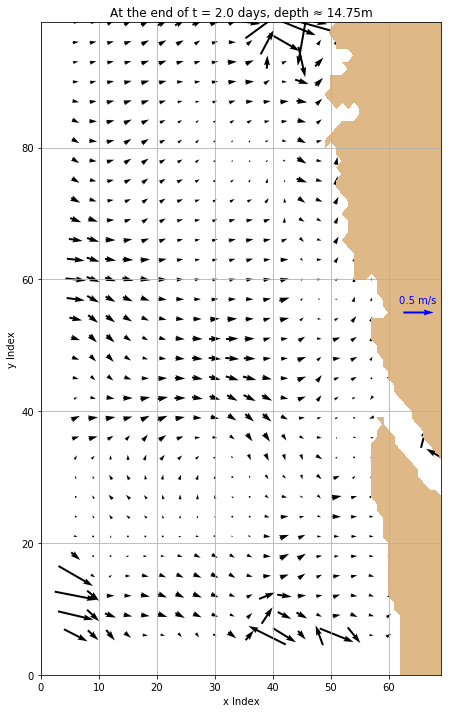

In [28]:

u_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_U.nc')
v_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_V.nc')
w_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_W.nc')

bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']
zlevels = u_vel.variables['depthu']
timesteps = u_vel.variables['time_counter']





# Define the slice to plot
t, zlevel = 47 , 0
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
# Axes limits and grid
ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1)/24, d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')

### We observe high velocities at the north east and south west corners (at the surface of the ocean) which means they are the barotropic wave speed

We also observed some reflected barotropic waves at the south east corner of our domain

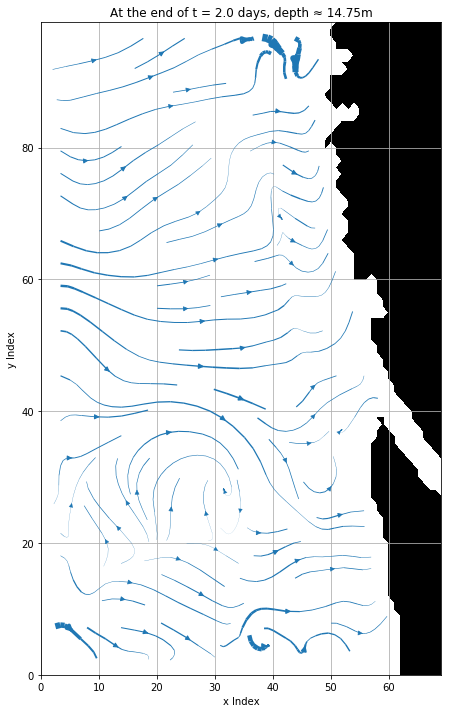

In [31]:
t, zlevel = 47, 0
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
max_speed = viz_tools.calc_abs_max(speeds)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)

ax.streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=10*speeds/max_speed,
)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1)/24, d=zlevels[zlevel], z=zlevels))

### Let us look for the winds on this day (we see a downwelling pattern on this day)

End of 2nd day means 3rd April Completed and 4th April starting (our run starts from 2nd April)

In [4]:
atmos_forcing_file = nc.Dataset('/ocean/ssahu/CANYONS/nemo-forcing/43_days_JP_primitive/ops_y2016m04d03.nc')

In [5]:
nc_tools.show_variables(atmos_forcing_file)

odict_keys(['atmpres', 'nav_lat', 'nav_lon', 'precip', 'qair', 'solar', 'tair', 'therm_rad', 'time_counter', 'u_wind', 'v_wind', 'x', 'y'])


In [6]:
u_wind = atmos_forcing_file.variables['u_wind'][:]
v_wind = atmos_forcing_file.variables['v_wind'][:]

In [11]:
v_wind.shape

(24, 400, 300)

IndexError: integer index exceeds dimension size

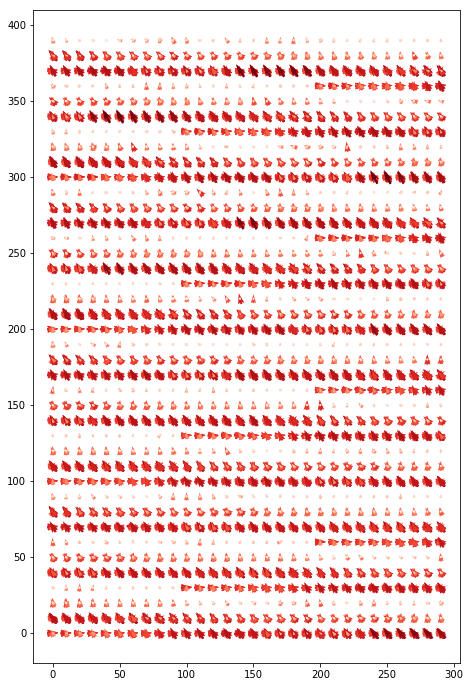

In [24]:
atmos_forcing_file = nc.Dataset('/ocean/ssahu/CANYONS/nemo-forcing/43_days_JP_primitive/ops_y2016m04d03.nc')
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



u_wind = atmos_forcing_file.variables['u_wind']
v_wind = atmos_forcing_file.variables['v_wind']
timesteps =u_wind.shape[0]





# Define the slice to plot
t = 23
y_slice = np.arange(0, 400)
x_slice = np.arange(0, 300)
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(u_wind[t,  y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(v_wind[t,  y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 10
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


X,Y = np.meshgrid(x_slice_a,y_slice_a)

# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(X, Y, u_tzyx[::3,::3], v_tzyx[::3,::3], speeds[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice)
# Axes limits and grid
ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1)/24, d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='white', labelcolor='white')

In [34]:
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

%matplotlib inline

In [ ]:
# plt.rcParams['font.size'] = 12


In [ ]:
# def reshape_grid(tmask, gridX, gridY):
    
#     ngrid = tmask.shape[0] * tmask.shape[1]
#     tmask = tmask.reshape(ngrid)
#     ngrid_water = tmask.sum()
#     gridX = gridX.reshape(ngrid)[tmask]
#     gridY = gridY.reshape(ngrid)[tmask]
    
#     return tmask, gridX, gridY, ngrid, ngrid_water

In [ ]:
# # Get mask and grid files
# mask = xr.open_dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/mesh_mask.nc')

# # Mask
# tmask = mask.tmask.isel(t=0).values.astype(bool)
# tmask[:, 750:, :] = 0
# tmask[:, :350, :] = 0
# tmask[:, :, :100] = 0

# # Grid
# gridX, gridY = np.meshgrid(mask.x, mask.y)

# # Full Grid Surface
# tmask_full = tmask[0, :, :]
# ngrid = tmask_full.shape[0] * tmask_full.shape[1]
# tmask_full = tmask_full.reshape(ngrid)
# ngrid_water = tmask_full.sum()
# gridX_full = gridX.reshape(ngrid)[tmask_full]
# gridY_full = gridY.reshape(ngrid)[tmask_full]

# # Sub Grid Surface
# tmask_sub_0 = tmask[0, ::5, ::5]
# nsubgrid = tmask_sub_0.shape[0] * tmask_sub_0.shape[1]
# tmask_sub_0 = tmask_sub_0.reshape(nsubgrid)
# nsubgrid_water_0 = tmask_sub_0.sum()
# gridX_sub_0 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_0]
# gridY_sub_0 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_0]

# # Sub Grid 20 m
# tmask_sub_10 = tmask[18, ::5, ::5].reshape(nsubgrid)
# nsubgrid_water_10 = tmask_sub_10.sum()
# gridX_sub_10 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_10]
# gridY_sub_10 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_10]

# # Depth
# deptht = mask.gdept_0.isel(t=0).values
# deptht = deptht.reshape(-1, ngrid)[:, tmask_full]
# dz = np.diff(deptht, axis=0)

In [ ]:
# /

In [ ]:
# # Timerange
# timerange = ['2016 Apr 03 00:00', '2016 Apr 04 23:00']
# timeslice = slice(timerange[0], timerange[1])

# # Load Wind
# wind = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
# u_wind = wind.sel(time=timeslice).u_wind.values.reshape(-1, ngrid_GEM)
# v_wind = wind.sel(time=timeslice).v_wind.values.reshape(-1, ngrid_GEM)
# u_wind_trim = np.zeros((u_wind.shape[0], ngrid_GEM_water))
# v_wind_trim = np.zeros((v_wind.shape[0], ngrid_GEM_water))
# for tindex, timerows in enumerate(zip(u_wind, v_wind)):
#     u_wind_trim[tindex, :] = timerows[0][mask_GEM]
#     v_wind_trim[tindex, :] = timerows[1][mask_GEM]
# GEM = {
#     'u_wind': u_wind_trim,
#     'v_wind': v_wind_trim
# }

In [ ]:
# u_wind_trim.shape

In [ ]:
# v_wind_trim.shape

In [ ]:
# plt.pcolormesh(u_wind_trim)

In [ ]:
# plt.barbs(u_wind,v_wind)

In [14]:
y_slice.shape

(400,)

In [43]:
u_wind.shape

(24, 400, 300)

In [22]:
type(ugrid)

netCDF4._netCDF4.Variable

In [23]:
type(u_wind)

numpy.ndarray

In [5]:
nc_tools.show_variables(nc.Dataset(bathy))

odict_keys(['nav_lon', 'nav_lat', 'Bathymetry'])


In [7]:
bathy_file = nc.Dataset(bathy)

lon = bathy_file.variables['nav_lon'][:]
lat = bathy_file.variables['nav_lat'][:]


X = lon.flatten()
Y = lat.flatten()

points = (X[:],Y[:])

big_lon_atmos = atmos_forcing_file.variables['nav_lon'][:]

big_lon = np.empty_like(big_lon_atmos)
big_lon[:] = big_lon_atmos[:] - 360

big_lat = atmos_forcing_file.variables['nav_lat'][:]

X_big = big_lon.flatten()
Y_big = big_lat.flatten()

xi = (X_big[:],Y_big[:])

interp_wind_u = np.empty((u_wind.shape[0], lon.shape[0], lon.shape[1]))
interp_wind_v = np.empty_like(interp_wind_u)

for i in np.arange(u_wind.shape[0]):
    interp_wind_u[i,...] = np.reshape(griddata(xi, u_wind[i,...].flatten(), points, method= 'linear'), lon.shape)
    interp_wind_v[i,...] = np.reshape(griddata(xi, v_wind[i,...].flatten(), points, method= 'linear'), lon.shape)




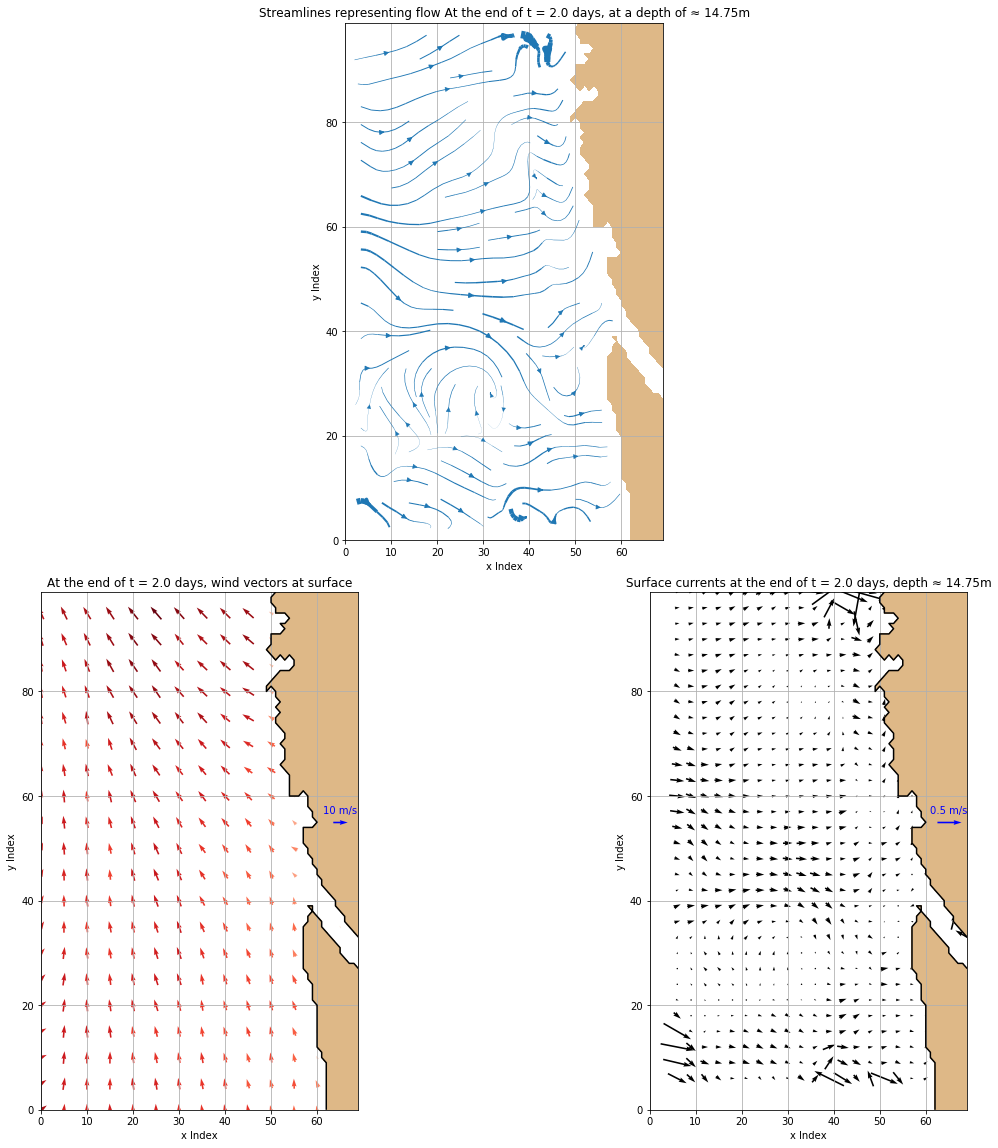

In [69]:
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
t = 23


ax = [0, 0, 0]
# date_NW = parse('2016 May 7 12:00')
# date_SE = parse('2016 Oct 15 12:00')

fig = plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.1)

ax[0] = plt.subplot(gs[0,:])
ax[1] = plt.subplot(gs[1:, 0])
ax[2] = plt.subplot(gs[1:, 1])
# Slice and mask the arrays
# ugrid_tzyx = np.ma.masked_values(interp_wind_u[:, :], 0)
# vgrid_tzyx = np.ma.masked_values(interp_wind_v[:, :], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx_wind, v_tzyx_wind = viz_tools.unstagger(interp_wind_u[t,...], interp_wind_v[t,...])
speeds_wind = np.sqrt(np.square(u_tzyx_wind) + np.square(v_tzyx_wind))


arrow_step = 5
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


X,Y = np.meshgrid(x_slice_a,y_slice_a)

# Plot the velocity vectors

# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax[1])
quiver = ax[1].quiver(X, Y, u_tzyx_wind[::arrow_step,::arrow_step], v_tzyx_wind[::arrow_step,::arrow_step], speeds_wind[::arrow_step,::arrow_step] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax[1], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax[1], bathy)

# Axes limits and grid
ax[1].set_xlim(x_slice[0], x_slice[-1])
ax[1].set_ylim(y_slice[0], y_slice[-1])
ax[1].grid()
# Axes label and title
ax[1].set_xlabel('x Index')
ax[1].set_ylabel('y Index')
ax[1].set_title('At the end of t = {0} days, wind vectors at surface'.format((t+1+24)/24))
ax[1].quiverkey(quiver, 65, 55, 10, '10 m/s', coordinates='data', color='blue', labelcolor='blue')


# Define the slice to plot
zlevel =  0

# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t+24, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t+24, zlevel, y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
# fig, ax[1] = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax[2])
quiver = ax[2].quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax[2], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax[2], bathy)
# Axes limits and grid
ax[2].set_xlim(x_slice[0], x_slice[-1])
ax[2].set_ylim(y_slice[0], y_slice[-1])
ax[2].grid()
# Axes label and title
ax[2].set_xlabel('x Index')
ax[2].set_ylabel('y Index')
ax[2].set_title('Surface currents at the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1+24)/24, d=zlevels[zlevel], z=zlevels))
ax[2].quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')



viz_tools.set_aspect(ax[0])

ax[0].streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=10*speeds/max_speed,
)
viz_tools.plot_land_mask(ax[0], bathy, xslice=x_slice, yslice=y_slice, color='burlywood')

ax[0].set_xlim(x_slice[0], x_slice[-1])
ax[0].set_ylim(y_slice[0], y_slice[-1])
ax[0].grid()

ax[0].set_xlabel('x Index')
ax[0].set_ylabel('y Index')
ax[0].set_title('Streamlines representing flow At the end of t = {0} days, at a depth of \u2248 {d:.2f}{z.units}'.format((t+1+24)/24, d=zlevels[zlevel], z=zlevels))

In [16]:
nc_tools.show_variables(atmos_forcing_file)

odict_keys(['atmpres', 'nav_lat', 'nav_lon', 'precip', 'qair', 'solar', 'tair', 'therm_rad', 'time_counter', 'u_wind', 'v_wind', 'x', 'y'])


In [29]:
interp_wind_u[y_slice.shape-1, x_slice.shape-1]

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [26]:
type(x_slice)

numpy.ndarray

In [27]:
type(interp_wind_u)

numpy.ndarray

In [31]:
type(ugrid)

netCDF4._netCDF4.Variable

In [38]:
np.mean(interp_wind_u)

nan

In [39]:
np.min(interp_wind_u)

nan

In [47]:
np.isnan(u_wind[-1,...])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [68]:
lon

array([[-487.00189209, -486.95602417, -486.91015625, ..., -483.92892456,
        -483.88305664, -483.83718872],
       [-487.03308105, -486.98648071, -486.93994141, ..., -483.93103027,
        -483.88513184, -483.83947754],
       [-487.06420898, -487.01690674, -486.96969604, ..., -483.9329834 ,
        -483.88696289, -483.84127808],
       ..., 
       [-489.40786743, -489.36297607, -489.3182373 , ..., -486.28488159,
        -486.23016357, -486.17486572],
       [-489.43652344, -489.39160156, -489.34680176, ..., -486.33148193,
        -486.27624512, -486.21990967],
       [-489.46502686, -489.42007446, -489.37530518, ..., -486.37908936,
        -486.32342529, -486.26577759]], dtype=float32)

In [64]:
big_lon

array([[ 230.093688  ,  230.12131004,  230.14894017, ...,  238.60619675,
         238.63572551,  238.66525875],
       [ 230.08528964,  230.11292378,  230.14056601, ...,  238.60183767,
         238.63138133,  238.66092946],
       [ 230.07688317,  230.10452941,  230.13218376, ...,  238.59747409,
         238.62703266,  238.65659571],
       ..., 
       [ 225.9795839 ,  226.01282649,  226.04608388, ...,  236.43269026,
         236.46955473,  236.50642802],
       [ 225.96680511,  226.00006415,  226.03333802, ...,  236.42580942,
         236.46269681,  236.49959303],
       [ 225.95401148,  225.98728698,  226.02057733, ...,  236.41891973,
         236.45583005,  236.49274922]])

In [50]:
interp_wind_u

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [51]:
big_lon

array([[ 230.093688  ,  230.12131004,  230.14894017, ...,  238.60619675,
         238.63572551,  238.66525875],
       [ 230.08528964,  230.11292378,  230.14056601, ...,  238.60183767,
         238.63138133,  238.66092946],
       [ 230.07688317,  230.10452941,  230.13218376, ...,  238.59747409,
         238.62703266,  238.65659571],
       ..., 
       [ 225.9795839 ,  226.01282649,  226.04608388, ...,  236.43269026,
         236.46955473,  236.50642802],
       [ 225.96680511,  226.00006415,  226.03333802, ...,  236.42580942,
         236.46269681,  236.49959303],
       [ 225.95401148,  225.98728698,  226.02057733, ...,  236.41891973,
         236.45583005,  236.49274922]])

In [52]:
lon

array([[-127.00188446, -126.95601654, -126.91014862, ..., -123.92892456,
        -123.88305664, -123.83718872],
       [-127.0330658 , -126.98648071, -126.93994904, ..., -123.9310379 ,
        -123.88513184, -123.83946991],
       [-127.06419373, -127.01689911, -126.96969604, ..., -123.93299866,
        -123.88694763, -123.84128571],
       ..., 
       [-129.40786743, -129.36299133, -129.31822205, ..., -126.28487396,
        -126.23016357, -126.17485809],
       [-129.43650818, -129.39160156, -129.34680176, ..., -126.33148956,
        -126.27624512, -126.21989441],
       [-129.4650116 , -129.42007446, -129.37528992, ..., -126.37909698,
        -126.32341766, -126.26578522]], dtype=float32)

In [56]:
np.max(lat)

50.347576

In [57]:
np.max(lat)

50.347576

In [65]:
236-360

-124